# Semantic Segmentation using DeepLab
##### **V Harikrishnan for Pivotchain**

[Github](https://github.com/hazkaz)
[LinkedIn](https://www.linkedin.com/in/v-hari-krishnan-39302bb5/)

## Brief Summary of Problem

Given an arbitrary image of arbitrary dimensions, output a segmented image; one that assigns a class to each pixel on the image for a set of pre-defined classes.

Below is an example of Image Segmentation performed on a scene of a road




In [19]:
%%html
<div style="display:flex;justify-content:space-around">
  <figure style="width:40%;display:inline-block;">
    <figcaption>Input Image</figcaption>
    <img src="http://mi.eng.cam.ac.uk/~agk34/demo_segnet/demo_images_wild/img3.jpg" />
  </figure>
  <figure style="width:45%;display:inline-block;">
    <figcaption>Segmented Image</figcaption>
    <img src="http://mi.eng.cam.ac.uk/~agk34/demo_segnet/demo_images_wild/img3.jpg_segnet.png" />
  </figure>
</div>

## Outline

Following steps are performed for semantic segmentation

1. Load Deeplab model v3+
2. Load image
3. Run Inference
4. Show output

## Import Libraries

In [0]:
%matplotlib inline
%tensorflow_version 2.x

import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
import tarfile
import os
import urllib
from IPython.core.display import HTML,display


In [0]:
if "semantic-segmentation-deeplab" not in os.listdir():
  !git clone https://github.com/hazkaz/semantic-segmentation-deeplab
!cp -f semantic-segmentation-deeplab/images/*.jpg .

## Download and Extract Pre-trained Model

In [0]:
#  Download and Extract Model frozen graph
tar_url = "http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz"
tar_name = "deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz"

if tar_name not in os.listdir():
  urllib.request.urlretrieve(tar_url,os.path.join('.',tar_name))

frozen_graph = "frozen_inference_graph.pb"
extracted_file_path = None

with tarfile.open('/content/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz') as tar_contents:
  for file in tar_contents.getmembers():
    if frozen_graph in file.name:
      tar_contents.extract(file)
      extracted_file_path = os.path.join(os.getcwd(),file.name)
      break

## Load Pre-trained Model from ".pb" file to a concrete function(Tensorflow 2.0)

In [0]:
# Code for compatibility with tensorflow 2.x
def wrap_frozen_graph(graph_def, inputs, outputs):
  def _imports_graph_def():
    tf.compat.v1.import_graph_def(graph_def, name="")
  wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
  import_graph = wrapped_import.graph
  return wrapped_import.prune(
      tf.nest.map_structure(import_graph.as_graph_element, inputs),
      tf.nest.map_structure(import_graph.as_graph_element, outputs))
  
# Parse pb model and get as Frozen Graph object
with open(extracted_file_path,'rb') as pb:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(pb.read())
  
# Create concrete function from graph object and define input and output tensor labels
deeplab_func = wrap_frozen_graph(graph_def,
                                 inputs='ImageTensor:0',
                                 outputs='SemanticPredictions:0')




## Run Model With a Sample Image

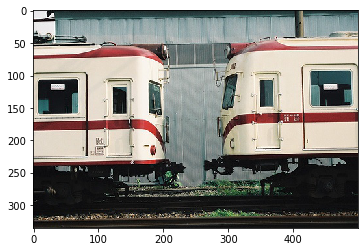

In [25]:
def segment_image(input_image):
  INPUT_SIZE = 513
  width, height = input_image.size
  # get the bigger dimension to fit the tensor
  resize_ratio = 1.0 * INPUT_SIZE / max(width, height)
  target_size = (int(resize_ratio * width), int(resize_ratio * height))
  resized_image = input_image.convert('RGB').resize(target_size, Image.ANTIALIAS)
  # convert image to tensor and feed to `deeplab_func` concrete function
  batch_seg_map = deeplab_func(tf.convert_to_tensor([np.asarray(resized_image)],dtype=tf.uint8))
  seg_map = batch_seg_map[0]
  return resized_image, seg_map

sample_image = 'image5.jpg'

image = Image.open(sample_image)
plt.imshow(image)

resized_image, seg_map = segment_image(image);

## Helper Functions for Output Visualization
Helper functions mostly re-used from the original source code at
 https://github.com/tensorflow/models/tree/master/research/deeplab


In [0]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)

def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
      A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


## Test on VOC2012 Dataset

In [36]:
def run_deeplab(image_file_name):
  print(image_file_name)
  image = Image.open(image_file_name)
  resized_image, seg_map = segment_image(image)
  vis_segmentation(resized_image, seg_map)

display(HTML('<h3 style="margin-bottom:15px">Select an image from the dropdown to run the image through the deeplab segmentation network</h3>'))

widgets.interact(run_deeplab,image_file_name=[f"image{i}.jpg" for i in range(1,11)],description="Select an image from the VOC2012 Dataset");

interactive(children=(Dropdown(description='image_file_name', options=('image1.jpg', 'image2.jpg', 'image3.jpg…